In [1]:
import sys
import os
sys.path.append('..')
from adjoint_esn.dynamical_systems import Lorenz63, Lorenz96
import adjoint_esn.solve_ode as solve_ode
import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.esn import ESN
from adjoint_esn.utils import preprocessing as pp

In [2]:
# run lorenz63 system
my_lorenz63 = Lorenz63(beta=8/3, rho=28, sigma=10, t_lyap=0.906**(-1))

dt = 1e-2

t_transient_len = 200
t_washout_len = 2
t_train_len = 50*my_lorenz63.t_lyap
t_val_len = 15*my_lorenz63.t_lyap
t_sim_len = t_transient_len+2*t_washout_len+t_train_len+t_val_len

upsample = 2
t_sim = np.arange(0,t_sim_len,dt/upsample)
rnd = np.random.RandomState(seed = 10)
u0 = rnd.random((my_lorenz63.N_dim)) 
U_sim = solve_ode.integrate(my_lorenz63, u0, t_sim, integrator='forward_euler')

Running solver.


In [168]:
# run lorenz96 system
my_lorenz96 = Lorenz96(p = 8.0, t_lyap = 1.2**(-1))

dt = 1e-2

t_transient_len = 200
t_washout_len = 2
t_train_len = 50*my_lorenz96.t_lyap
t_val_len = 15*my_lorenz96.t_lyap
t_sim_len = t_transient_len+2*t_washout_len+t_train_len+t_val_len

upsample = 2
t_sim = np.arange(0,t_sim_len,dt/upsample)
rnd = np.random.RandomState(seed = 10)
u0 = rnd.random((6)) 
U_sim = solve_ode.integrate(my_lorenz96, u0, t_sim, integrator='forward_euler')[:,2][:,None]

Running solver.


In [2]:
# load rijke system from data
data_path = "data/rijke_kings_beta_7_tau_0_2_long.h5"
data_dict = pp.read_h5(data_path)

dt = 1e-1

t_transient_len = data_dict["t_transient"]
t_washout_len = 4
t_train_len = 256
t_val_len = 64

data_dt = data_dict["t"][1]-data_dict["t"][0]
upsample = int(np.round(dt/data_dt))

pres = data_dict["P"][:,1:-1]
pres_single = data_dict["P"][:,5][:,None]
vel = data_dict["U"]
pres_vel = np.hstack((data_dict["P"][:,1:-1],data_dict["U"]))

U_sim = pres_single
t_sim = data_dict["t"]

In [3]:
# upsample
U = U_sim[::upsample,:]
t = t_sim[::upsample]

# cut the transient    
N_transient = int(np.round(t_transient_len/dt))
U = U[N_transient:,:]
t = t[N_transient:]-t[N_transient]

# separate into washout, train, val
N_washout = int(np.round(t_washout_len/dt))
N_train = int(np.round(t_train_len/dt))
N_val = int(np.round(t_val_len/dt))

U_washout_train = U[0:N_washout,:]

U_train = U[N_washout:N_washout+N_train-1,:]
Y_train = U[N_washout+1:N_washout+N_train,:]
t_train = t[N_washout+1:N_washout+N_train]

U_washout_val = U[N_washout+N_train:2*N_washout+N_train,:]
U_val = U[2*N_washout+N_train:2*N_washout+N_train+N_val-1,:]
Y_val = U[2*N_washout+N_train+1:2*N_washout+N_train+N_val,:]
t_val = t[2*N_washout+N_train+1:2*N_washout+N_train+N_val]

In [69]:
U_data = U[:N_washout+N_train]
U_mean = U_data.mean(axis = 0)
U_std = U_data.std(axis = 0)
m = U_data.min(axis=0)
M = U_data.max(axis=0)
U_norm = M-m 
scale = (U_mean, U_std)

In [71]:
input_bias = np.array([np.mean(np.abs((U_data-scale[0])/scale[1]))])
print('Input bias: ', input_bias)
dim = U_sim.shape[1]
print('System dimension: ', dim)
my_ESN = ESN(reservoir_size = 1000, dimension = dim, reservoir_connectivity = 3, 
                input_scaling = 0.8, spectral_radius = 1.0,
                leak_factor = 1.0, input_bias = input_bias)

Input bias:  [0.81412858]
System dimension:  1
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.


In [72]:
my_ESN.train(U_washout_train, U_train, Y_train, tikhonov = 1e-1, scale = scale)

In [73]:
X_pred_train, Y_pred_train = my_ESN.closed_loop_with_washout(U_washout_train, N_t = N_train-1, scale = scale)
Y_pred_train = Y_pred_train[1:,:]

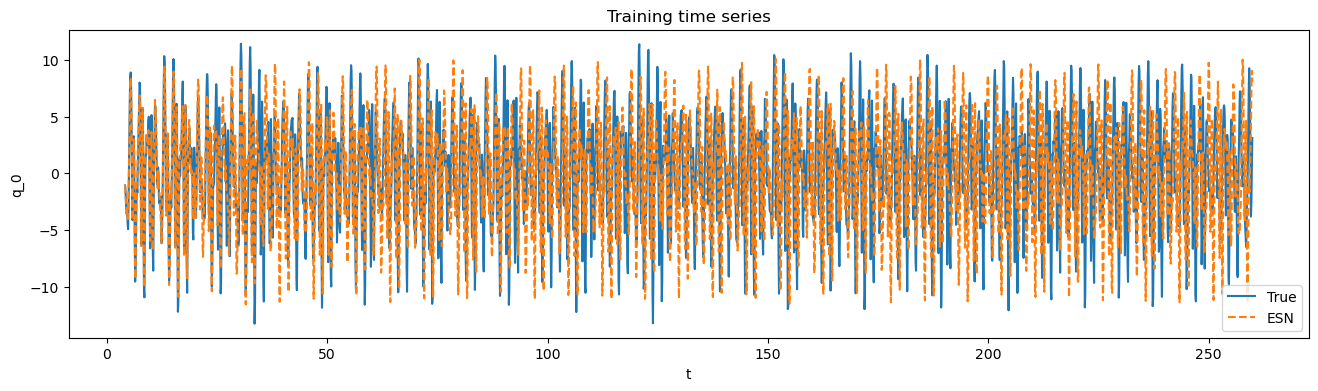

In [74]:
#my_lorenz63.t_lyap
for j in range(1):
    plt.figure(figsize=(16,4))
    plt.plot(t_train, Y_train[:,j])
    plt.plot(t_train, Y_pred_train[:,j],'--')
    plt.title("Training time series")
    plt.xlabel("t")
    plt.ylabel(f"q_{j}")
    plt.legend(["True", "ESN"])

In [75]:
X_pred_val, Y_pred_val = my_ESN.closed_loop_with_washout(U_washout_val, N_t = N_val-1, scale = scale)
Y_pred_val = Y_pred_val[1:,:]

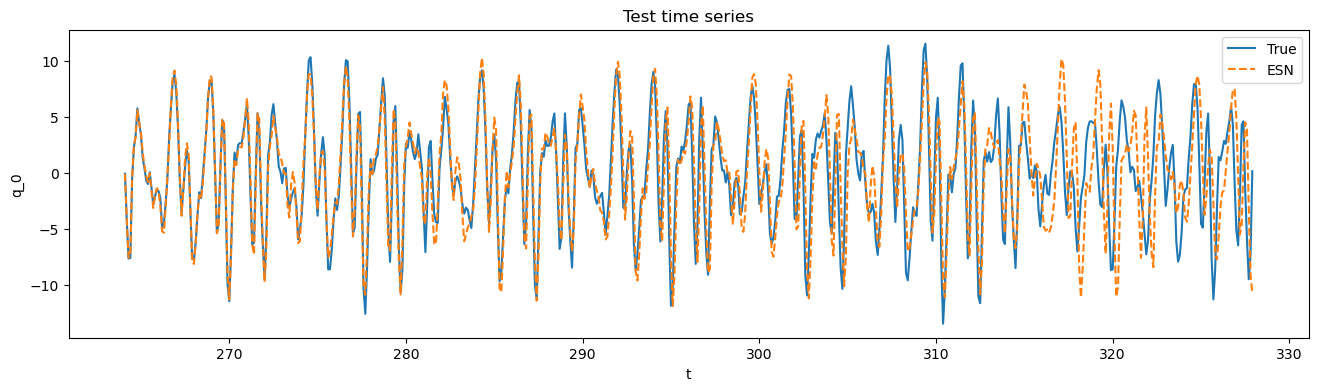

In [76]:
#my_lorenz63.t_lyap
for j in range(1):
    plt.figure(figsize=(16,4))
    plt.plot(t_val, Y_val[:,j])
    plt.plot(t_val, Y_pred_val[:,j],'--')
    plt.title("Test time series")
    plt.xlabel("t")
    plt.ylabel(f"q_{j}")
    plt.legend(["True", "ESN"])

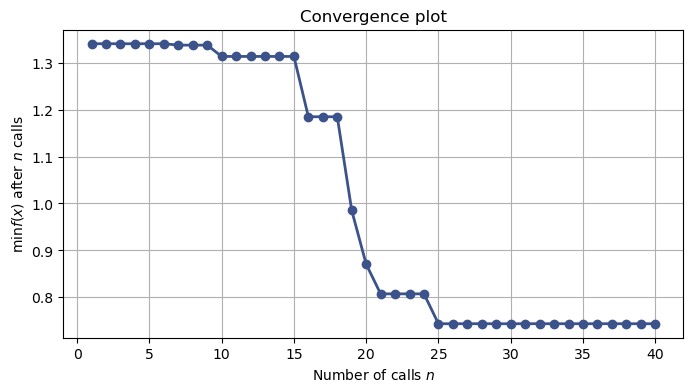

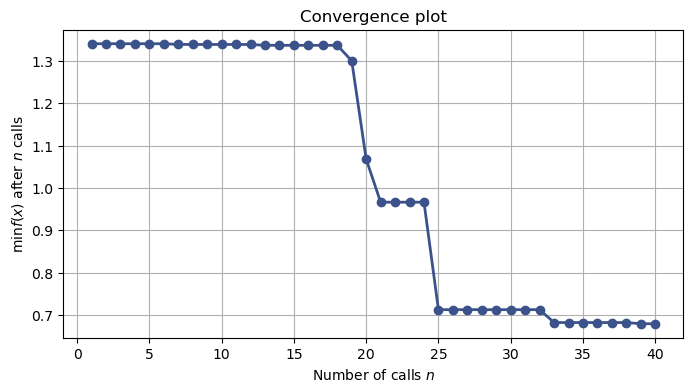

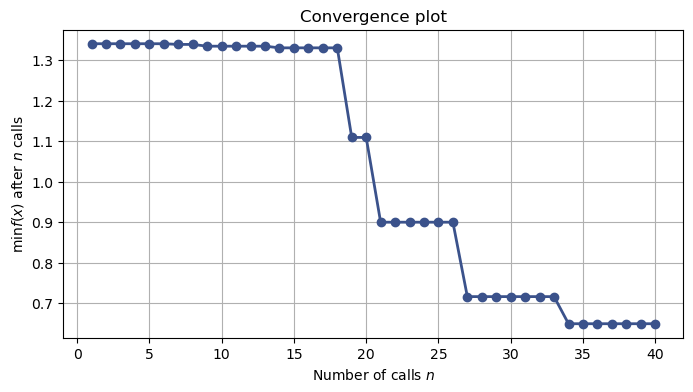

In [36]:
from adjoint_esn.validation import validate

#range for hyperparameters (spectral radius and input scaling)
spec_in     = .1    
spec_end    = 1.   
in_scal_in  = np.log10(0.05)
in_scal_end = np.log10(5.)
leak_in     = .1    
leak_end    = 1.   
grid_range = [[spec_in, spec_end], [in_scal_in, in_scal_end]]

# In case we want to start from a grid_search, 
# the first n_grid_x*n_grid_y points are from grid search
n_grid_x = 6 
n_grid_y = 6
#n_grid_z = 4

param_names = ['spectral_radius', 'input_scaling']
param_scales = ['uniform', 'log10']
n_grid = [n_grid_x, n_grid_y]

ESN_dict = {'reservoir_size': 1000, 
            'dimension' : dim, 
            'reservoir_connectivity' : 3, 
            'input_bias' : input_bias}
min_dict = validate(n_grid, grid_range, param_names, param_scales, 
    n_bo = 4, n_initial = 0, n_ensemble = 3, ESN_dict = ESN_dict, U_washout = U_washout_train, 
    U = U_train, Y = Y_train, data_scale = scale, n_folds = 20, N_init_steps = N_washout, N_fwd_steps = 40, N_washout_steps = N_washout, N_val_steps = N_val)

In [37]:
min_dict

{'params': array([[0.82     , 0.05     ],
        [1.       , 0.2707554],
        [1.       , 0.7924466]]),
 'tikh': [1e-06, 1, 0.1],
 'f': array([0.74379084, 0.67928005, 0.64888024])}

In [ ]:
#Win  (100, 4) Wout  (101, 3)    
#Win = my_ESN.input_weights
#W = my_ESN.reservoir_weights
#sigma_in = my_ESN.input_scaling
#norm = U_norm
#Wout = my_ESN.output_weights
#N_units = my_ESN.N_reservoir
#rho = my_ESN.spectral_radius
#dfdu = np.r_[np.diag(sigma_in/norm),[np.zeros(dim)]] # (4,3)
#d = Win.dot(dfdu) # test consistent (100,4)x(4,3) = 100,3   
#c = np.matmul(d,Wout[:N_units,:].T) #(100,3)x(3,100)=(100,100)
#c = d.dot(Wout.T)
#bb = W.dot(np.diag(np.ones(N_units)*rho))